NAMA : SATRIO ADI BASKORO
NIM  : 362358302007

# Bagian 1: Impor Libraries
Bagian pertama ini berisi semua library yang kita butuhkan.
- math: Untuk perhitungan matematika (akar kuadrat) di Cosine Similarity.
- pandas: Untuk membaca file CSV dan mengelola data dalam bentuk tabel.
- re: Untuk Regular Expressions, digunakan untuk membersihkan teks (misal: '16GB' -> 16).
- matplotlib.pyplot: Untuk membuat visualisasi (grafik batang).

In [10]:
import math  # Untuk perhitungan matematika (akar kuadrat) di Cosine Similarity.
import pandas as pd  # Untuk membaca file CSV dan membuat tabel data (DataFrame).
import re  # Untuk Regular Expressions, membersihkan teks seperti '16GB'.
import matplotlib.pyplot as plt  # Untuk membuat visualisasi (grafik batang).

# Bagian 2
Bagian ini berisi kumpulan fungsi-fungsi kecil yang melakukan satu tugas spesifik. Tugas utama mereka adalah untuk "membersihkan" dan "mengelompokkan" data mentah agar bisa diproses.

In [11]:
def clean_string(text):
    #Mengubah string '16GB' atau '512GB' menjadi angka 16 atau 512.
    if pd.isna(text): return 0
    match = re.search(r'(\d+)', str(text))
    return int(match.group(1)) if match else 0

def convert_gpu_type(gpu_string):
    #Mengonversi teks GPU menjadi kategori (1=Integrated, 2=Dedicated).
    gpu_str = str(gpu_string).lower()
    if "nvidia" in gpu_str or "amd" in gpu_str: return 2
    elif "intel" in gpu_str or "iris" in gpu_str: return 1
    return 0 

def convert_ram(ram_gb):
    #Mengelompokkan RAM.
    if ram_gb <= 8: return 1
    elif ram_gb <= 16: return 2
    else: return 3

def convert_storage(storage_gb):
    #Mengelompokkan Storage.
    if storage_gb <= 512: return 1
    elif storage_gb <= 1024: return 2
    else: return 3

def convert_price(price):
    #Mengelompokkan (binning) Harga.
    if price <= 40000: return 1
    elif price <= 60000: return 2
    else: return 3

def convert_rating(rating):
    #Mengelompokkan (binning) Rating.
    if rating <= 65: return 1
    elif rating <= 75: return 2
    else: return 3

def convert_display(size):
    #Mengelompokkan (binning) Ukuran Layar.
    if size <= 14: return 1
    elif size <= 16: return 2
    else: return 3

# Bagian 3 
Ini adalah "jantung" dari program yang menjalankan 4 langkah inti CBR. load_case_base_from_csv: Membaca data.csv dan mengubahnya menjadi "Basis Kasus" (memori sistem). specs_to_vector: 🧠 "Otak" CBR.Menerjemahkan data laptop (Problem) menjadi Vektor angka. cosine_similarity: 📐 "Kalkulator" CBR. Menghitung skor kemiripan antara dua vektor. find_similar_cases: 🔄 "Mesin Pencari" (Retrieve). Mencari di seluruh basis kasus dan mengurutkan laptop dari yang paling mirip.

In [12]:
def load_case_base_from_csv(file_path):
    #(Tahap 1: Load) Membaca file CSV dan mengubahnya menjadi 'case_base'.
    try:
        df = pd.read_csv(file_path)
        print(f"Sukses memuat {len(df)} data laptop dari {file_path}")
    except FileNotFoundError:
        print(f"Error: File '{file_path}' tidak ditemukan. (Pastikan Anda sudah upload file jika di Colab)")
        return []
    
    case_base = []
    for _, row in df.iterrows():
        case = {
            "criteria": {  # "Problem" (Masalah)
                "price": float(row['price']),
                "spec_rating": float(row['spec_rating']),
                "Ram": clean_string(row['Ram']), 
                "ROM": clean_string(row['ROM']), 
                "GPU": str(row['GPU']),
                "display_size": float(row['display_size'])
            },
            "recommendation": row['name']  # "Solution" (Solusi)
        }
        case_base.append(case)
    return case_base

def specs_to_vector(specs):
    #(Tahap 2: Vectorize) "Otak" CBR. Mengubah 'specs' menjadi Vektor numerik.
    return [
        convert_price(specs["price"]),
        convert_ram(specs["Ram"]),
        convert_storage(specs["ROM"]),
        convert_gpu_type(specs["GPU"]),
        convert_rating(specs["spec_rating"]),
        convert_display(specs["display_size"])
    ]

def cosine_similarity(vector1, vector2):
    #(Tahap 3: Similarity) "Kalkulator" CBR. Menghitung kemiripan dua vektor.
    dot_product = sum(v1 * v2 for v1, v2 in zip(vector1, vector2))
    magnitude1 = math.sqrt(sum(v1**2 for v1 in vector1))
    magnitude2 = math.sqrt(sum(v2**2 for v2 in vector2))
    if magnitude1 == 0 or magnitude2 == 0: return 0
    return dot_product / (magnitude1 * magnitude2)

def find_similar_cases(case_base, new_criteria_vector):
    #(Tahap 4: Retrieve) "Mesin Pencari" CBR. Mencari dan mengurutkan semua kasus berdasarkan kemiripan.
    all_similarities = []
    
    for i, case in enumerate(case_base):
        case_vector = specs_to_vector(case["criteria"])
        similarity = cosine_similarity(new_criteria_vector, case_vector)
        
        all_similarities.append({
            "case_id": i,
            "laptop_name": case["recommendation"],
            "similarity": similarity,
            "specs": case["criteria"] 
        })
            
    return sorted(all_similarities, key=lambda x: x['similarity'], reverse=True)

# Bagian 4 
Bagian ini berisi fungsi-fungsi yang tidak melakukan perhitungan CBR, tetapi bertugas membuat "laporan" hasil analisis dalam bentuk file (CSV dan PNG). visualize_similarity: 📊 Membuat file gambar (.png) berisi grafik batang 10 laptop teratas. export_recommendations_to_csv: 🗂️ Membuat file laporan (.csv) berisi 5 laptop teratas.

In [13]:
def visualize_similarity(all_scores, new_specs, filename="visualisasi_rekomendasi.png"):
    # Membuat dan menyimpan visualisasi 10 kasus teratas ke file PNG.
    print(f"\nMembuat visualisasi perbandingan ke {filename}...")
    
    top_scores = all_scores[:10]
    labels = [f"Kasus {s['case_id']}\n({s['laptop_name'][:20]}...)" for s in reversed(top_scores)]
    scores = [s['similarity'] for s in reversed(top_scores)]

    plt.figure(figsize=(12, 7))
    bars = plt.barh(labels, scores, color='deepskyblue')
    
    for bar in bars:
        plt.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height() / 2,
                 f"{bar.get_width():.3f}", va='center')
    
    plt.xlabel('Tingkat Kemiripan (Cosine Similarity)')
    plt.ylabel('Basis Kasus (10 Teratas)')
    plt.title(f"Visualisasi Kemiripan (Rating > {new_specs['spec_rating']}, Budget ~{new_specs['price']})")
    plt.xlim(0, 1.1)
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    
    try:
        plt.savefig(filename)
        print(f"+++ Sukses! Visualisasi disimpan ke '{filename}' +++")
    except Exception as e:
        print(f"--- Gagal menyimpan visualisasi: {e} ---")

def export_recommendations_to_csv(top_scores, filename="rekomendasi_laptop.csv"):
    # Mengekspor 5 rekomendasi teratas ke file CSV.
    print(f"\nMengekspor 5 rekomendasi teratas ke {filename}...")
    
    data_to_export = top_scores[:5]
    export_list = []
    for item in data_to_export:
        flat_item = {
            "laptop_name": item['laptop_name'],
            "similarity_score": item['similarity'],
            "price": item['specs']['price'],
            "Ram_GB": item['specs']['Ram'],
            "ROM_GB": item['specs']['ROM'],
            "GPU_Info": item['specs']['GPU'],
            "spec_rating": item['specs']['spec_rating'],
            "display_size": item['specs']['display_size']
        }
        export_list.append(flat_item)

    df_export = pd.DataFrame(export_list)
    
    try:
        df_export.to_csv(filename, index=False, encoding='utf-8')
        print(f"+++ Sukses! File '{filename}' telah disimpan.")
    except Exception as e:
        print(f"--- Gagal mengekspor CSV: {e} ---")

# Bagian 5
Bagian ini membuat program menjadi interaktif. get_numeric_input: Fungsi pembantu untuk memastikan pengguna memasukkan angka dan bukan teks (validasi input). dapatkan_kebutuhan_pengguna: 🎤 Fungsi "wawancara" yang akan bertanya kepada pengguna dan mengumpulkan jawaban mereka menjadi "Kasus Baru".

In [14]:
def get_numeric_input(prompt, value_type=float):
    # Fungsi pembantu baru untuk memastikan input adalah angka.
    while True:  # Loop selamanya sampai mendapat input valid
        user_input = input(prompt)
        try:
            # Coba ubah input string menjadi tipe angka yang diinginkan
            value = value_type(user_input)
            return value
        except ValueError:
            # Jika gagal (misal pengguna ketik 'abc'), beri peringatan
            print(f"Input tidak valid. Harap masukkan angka (contoh: {value_type(10)}).")

def dapatkan_kebutuhan_pengguna():
    # Kegunaan: Fungsi baru untuk bertanya dan mendapatkan kebutuhan (kasus baru) langsung dari pengguna.
    print("--- Silakan Masukkan Kebutuhan Laptop Anda ---")
    
    price = get_numeric_input("Berapa budget (harga) maksimal Anda? (Contoh: 50000) ", float)
    ram = get_numeric_input("Berapa GB RAM minimal yang Anda butuhkan? (Contoh: 16) ", int)
    rom = get_numeric_input("Berapa GB Storage (ROM/SSD) minimal? (Contoh: 512) ", int)
    rating = get_numeric_input("Berapa minimal 'spec rating' yang Anda inginkan? (0-100, Contoh: 70) ", float)
    display = get_numeric_input("Berapa ukuran layar yang Anda inginkan? (dalam inch, Contoh: 15.6) ", float)
    
    gpu_text = "Nvidia RTX" # Default
    while True:
        gpu_choice = input("Pilih tipe GPU: [1] Integrated (Intel/Iris) atau [2] Dedicated (Nvidia/AMD) ")
        if gpu_choice == '1':
            gpu_text = "Intel Iris" # Ini akan diterjemahkan sbg Integrated
            break
        elif gpu_choice == '2':
            gpu_text = "Nvidia RTX" # Ini akan diterjemahkan sbg Dedicated
            break
        else:
            print("Input tidak valid. Harap pilih 1 atau 2.")

    # Kembalikan dictionary dengan format yang sama persis
    return {
        "price": price,
        "Ram": ram,
        "ROM": rom,
        "GPU": gpu_text,
        "spec_rating": rating,
        "display_size": display
    }

# BAGIAN 6 & 7
Ini adalah sel terakhir. main(): 🚀 "Manajer Proyek". Fungsi ini mengatur alur kerja program. Ia memanggil semua fungsi lain secara berurutan: Load -> Get Input -> Vectorize -> Find -> Report. if __name__ == "__main__":: "Tombol Start". Ini adalah baris yang memberi tahu Python untuk memulai program dengan menjalankan fungsi main().

Sukses memuat 893 data laptop dari data.csv
--- Silakan Masukkan Kebutuhan Laptop Anda ---

--- Memulai Proses CBR ---
Mencari berdasarkan Kebutuhan Pengguna: {'price': 50000.0, 'Ram': 8, 'ROM': 512, 'GPU': 'Intel Iris', 'spec_rating': 70.0, 'display_size': 14.0}
Vektor Kebutuhan (Problem): [2, 1, 1, 1, 2, 1]

Mencari kasus paling mirip di database...

Kasus ditemukan!
Skor Kemiripan Tertinggi: 1.0000 (di atas threshold 0.9)

--- REKOMENDASI FINAL ---
Rekomendasi untuk kriteria Anda adalah: Latitude 3410 Laptop

Membuat visualisasi perbandingan ke visualisasi_rekomendasi.png...
+++ Sukses! Visualisasi disimpan ke 'visualisasi_rekomendasi.png' +++

Mengekspor 5 rekomendasi teratas ke rekomendasi_laptop.csv...
+++ Sukses! File 'rekomendasi_laptop.csv' telah disimpan.


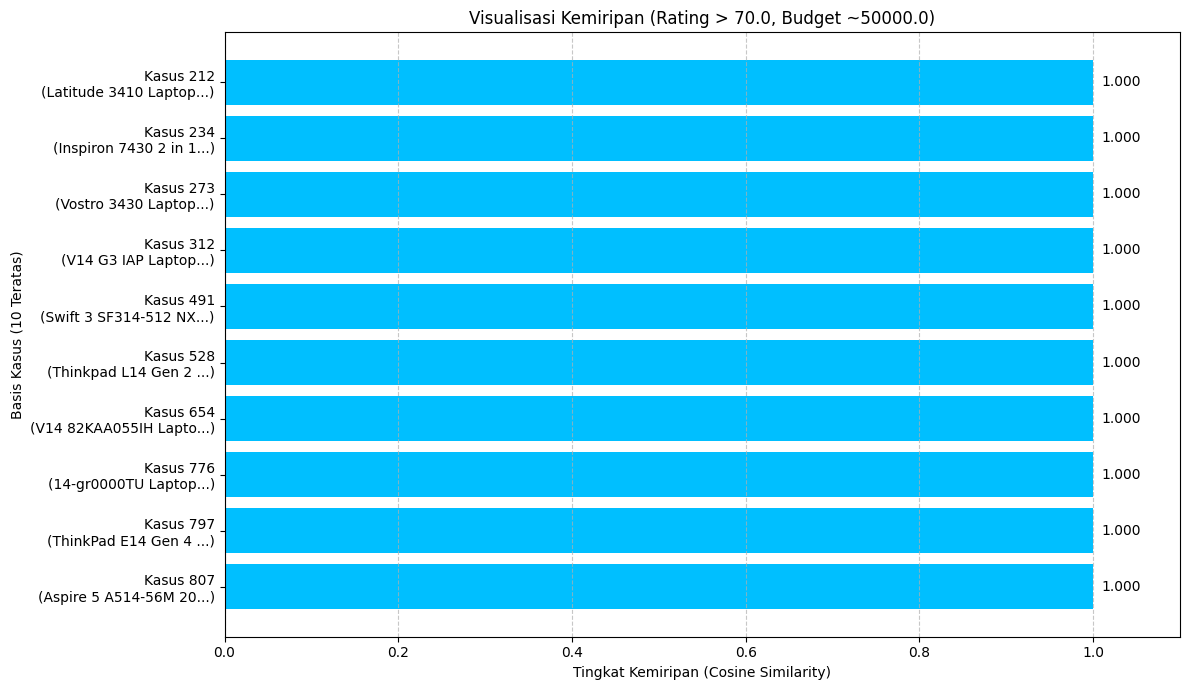

In [15]:
def main():
    # Kegunaan: Fungsi utama untuk menjalankan seluruh proses CBR. Cara Kerja: Memanggil semua fungsi lain secara berurutan.
    
    # --- 1. Setup Awal ---
    FILE_PATH = 'data.csv'  # Pastikan 'data.csv' ada di folder yang sama
    
    # --- 2. Muat Basis Kasus ---
    case_base = load_case_base_from_csv(FILE_PATH)
    if not case_base:
        print("Program berhenti karena data tidak berhasil dimuat.")
        return  # Hentikan program

    # --- 3. Dapatkan Kebutuhan Pengguna (MODIFIKASI) ---
    KEBUTUHAN_PENGGUNA = dapatkan_kebutuhan_pengguna()

    # --- 4. Jalankan Proses CBR ---
    print("\n--- Memulai Proses CBR ---")
    print(f"Mencari berdasarkan Kebutuhan Pengguna: {KEBUTUHAN_PENGGUNA}")
    
    # Ubah kebutuhan pengguna menjadi vektor (Problem)
    new_criteria_vector = specs_to_vector(KEBUTUHAN_PENGGUNA)
    print(f"Vektor Kebutuhan (Problem): {new_criteria_vector}")
    
    # Cari kasus (RETRIEVE)
    print("\nMencari kasus paling mirip di database...")
    all_scores = find_similar_cases(case_base, new_criteria_vector)
    
    if not all_scores:
        print("Gagal mencari kasus.")
        return

    # --- 5. Tentukan Rekomendasi (REUSE) ---
    best_case = all_scores[0]  # Ambil skor tertinggi
    similarity_score = best_case['similarity']
    threshold = 0.90  # Batas minimal kemiripan (90%)
    
    recommendation = "Tidak ada rekomendasi yang cocok."  # Default
    
    if similarity_score >= threshold:
        print(f"\nKasus ditemukan!")
        print(f"Skor Kemiripan Tertinggi: {similarity_score:.4f} (di atas threshold {threshold})")
        recommendation = best_case["laptop_name"]  # Ambil Solusi
    else:
        print(f"\nTidak ada kasus yang cukup mirip ditemukan.")
        print(f"Kasus terdekat adalah {best_case['laptop_name'][:20]}... (Skor: {similarity_score:.4f})")
    
    # --- 6. Cetak Hasil Akhir ---
    print("\n--- REKOMENDASI FINAL ---")
    print(f"Rekomendasi untuk kriteria Anda adalah: {recommendation}")

    # --- 7. Buat Laporan (Output) ---
    visualize_similarity(all_scores, KEBUTUHAN_PENGGUNA)
    export_recommendations_to_csv(all_scores)

# --- EKSEKUSI PROGRAM ---
# "Tombol Start" program.
# Ini akan memanggil fungsi main() saat Anda menjalankan sel ini.
if __name__ == "__main__":
    main()